# Выбор локации для скважины

Нефтяной компании нужно знать, где выгодно бурить новую скважину.
Есть пробы нефти в трёх регионах: в каждом 10 000 месторождений, измерено качество нефти и объём запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Возможную прибыль и риски проверим техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:

import numpy as np
import pandas as pd
!pip install seaborn -U
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from numpy.random import RandomState
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 983 kB/s eta 0:00:01


In [2]:

geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')


In [3]:
geo_data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [4]:
geo_data_1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [5]:
geo_data_2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Название столбцов соответствует содержимому.  
Все три датасета имеют одинаковую размерность.

In [6]:
geo_data_0.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


In [7]:
geo_data_1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


In [8]:
geo_data_2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


Пропущенных значений нет.  
Типы данных соответствуют содержимому.  
Датасеты занимают незначительный объем памяти.

In [9]:

print('Количество дубликатов в "geo_data_0":', geo_data_0.duplicated().sum())
print('Количество дубликатов в "geo_data_1":', geo_data_1.duplicated().sum())
print('Количество дубликатов в "geo_data_2":', geo_data_2.duplicated().sum())


Количество дубликатов в "geo_data_0": 0
Количество дубликатов в "geo_data_1": 0
Количество дубликатов в "geo_data_2": 0


Полные дубликаты отсутствуют.  
Проверим поле `id`, в не должно быть повторов.

In [10]:

print('Количество дубликатов в "geo_data_0.id":', geo_data_0['id'].duplicated().sum())
print('Количество дубликатов в "geo_data_1.id":', geo_data_1['id'].duplicated().sum())
print('Количество дубликатов в "geo_data_2.id":', geo_data_2['id'].duplicated().sum())


Количество дубликатов в "geo_data_0.id": 10
Количество дубликатов в "geo_data_1.id": 4
Количество дубликатов в "geo_data_2.id": 4


В `id` есть повторы.  
Следует уточнить какие признаки верны для данных `id`  
Пока удалим их полностью, так как точные признаки к ним неизвестны.

In [11]:

geo_data_0.drop(index=geo_data_0[geo_data_0['id'].duplicated()].index, inplace=True)
geo_data_0 = geo_data_0.reset_index(drop=True)
geo_data_1.drop(index=geo_data_1[geo_data_1['id'].duplicated()].index, inplace=True)
geo_data_1 = geo_data_1.reset_index(drop=True)
geo_data_2.drop(index=geo_data_2[geo_data_2['id'].duplicated()].index, inplace=True)
geo_data_2 = geo_data_2.reset_index(drop=True)

print('Количество дубликатов в "geo_data_0.id":', geo_data_0['id'].duplicated().sum())
print('Количество дубликатов в "geo_data_1.id":', geo_data_1['id'].duplicated().sum())
print('Количество дубликатов в "geo_data_2.id":', geo_data_2['id'].duplicated().sum())


Количество дубликатов в "geo_data_0.id": 0
Количество дубликатов в "geo_data_1.id": 0
Количество дубликатов в "geo_data_2.id": 0


Мы убрали строки с повторяющимися скважинами.

In [12]:
geo_data_0.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
f0,99990.0,0.500,0.872,-1.409,-0.073,0.502,1.074,2.362
f1,99990.0,0.250,0.504,-0.848,-0.201,0.250,0.701,1.344
f2,99990.0,2.503,3.248,-12.088,0.288,2.516,4.715,16.004
product,99990.0,92.500,44.288,0.000,56.497,91.848,128.564,185.364


In [13]:
geo_data_1.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
f0,99996.0,1.141,8.966,-31.610,-6.299,1.153,8.621,29.422
f1,99996.0,-4.797,5.120,-26.359,-8.268,-4.813,-1.333,18.734
f2,99996.0,2.495,1.704,-0.018,1.000,2.011,4.000,5.020
product,99996.0,68.824,45.945,0.000,26.953,57.086,107.813,137.945


In [14]:
geo_data_2.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
f0,99996.0,0.002,1.732,-8.760,-1.162,0.009,1.158,7.238
f1,99996.0,-0.002,1.730,-7.084,-1.175,-0.010,1.164,7.845
f2,99996.0,2.495,3.473,-11.970,0.130,2.484,4.859,16.739
product,99996.0,94.998,44.750,0.000,59.450,94.925,130.587,190.030


Минимальные запасы в каждом регионе неотрицательные, это указано верно, запасы не могут быть отрицательными.  
По среднему и медианному значению запасов лидирует `geo_data_2` (**95, 95**).  
Чуть меньше у `geo_data_0` (**93, 92**), `geo_data_1` (**69, 57**) заметно отстает.  

Выделим целевой признак.

In [15]:

target_0 = geo_data_0['product']
features_0 = geo_data_0.drop(['product'], axis=1)
target_1 = geo_data_1['product']
features_1 = geo_data_1.drop(['product'], axis=1)
target_2 = geo_data_2['product']
features_2 = geo_data_2.drop(['product'], axis=1)


Разобьем данные на обучающую и валидационную выборки в соотношении **75:25**

In [16]:

features_0_train, features_0_valid, target_0_train, target_0_valid =\
train_test_split(features_0, target_0, test_size=0.25, random_state=42)
features_1_train, features_1_valid, target_1_train, target_1_valid =\
train_test_split(features_1, target_1, test_size=0.25, random_state=42)
features_2_train, features_2_valid, target_2_train, target_2_valid =\
train_test_split(features_2, target_2, test_size=0.25, random_state=42)


In [17]:
print('Размер валидационной и обучающей выборок:\n', features_0_train.shape, '\n', features_0_valid.shape)

Размер валидационной и обучающей выборок:
 (74992, 4) 
 (24998, 4)


### Вывод:

Название столбцов соответствует содержимому.  
Все три датасета имеют одинаковую размерность.  
Пропущенных значений нет.  
Типы данных соответствуют содержимому.  
Датасеты занимают незначительный объем памяти и не нуждаются в оптимизации типов.  
Полные дубликаты отсутствуют.  
В `id` есть повторы - следует уточнить какие признаки верны для данных `id`  
По среднему и медианному значению запасов лидирует `geo_data_2` (**95, 95**).  
Чуть меньше у `geo_data_0` (**93, 92**), `geo_data_1` (**69, 57**) заметно отстает.  
Выделили целевой признак.  
Разобили данные на обучающую и валидационную выборки в соотношении **75:25**   
Теперь данные можно показывать модели.

## Обучение и проверка модели

Обучим модель и сделаем предсказание.  
Для обучения модели подходит линейная регрессия (остальные — недостаточно предсказуемые).

In [18]:

model_0 = LinearRegression(normalize=True)
model_0.fit(features_0_train.iloc[:, 1:], target_0_train)
predicted_0 = model_0.predict(features_0_valid.iloc[:, 1:])
model_1 = LinearRegression(normalize=True)
model_1.fit(features_1_train.iloc[:, 1:], target_1_train)
predicted_1 = model_1.predict(features_1_valid.iloc[:, 1:])
model_2 = LinearRegression(normalize=True)
model_2.fit(features_2_train.iloc[:, 1:], target_2_train)
predicted_2 = model_2.predict(features_2_valid.iloc[:, 1:])


In [19]:

print('Средний запас предсказанного сырья для "geo_data_0": {}, \nRMSE модели: {}\n'\
      .format(predicted_0.mean().round(3), np.sqrt(mean_squared_error(target_0_valid, predicted_0)).round(3)))
print('Средний запас предсказанного сырья для "geo_data_1": {}, \nRMSE модели: {}\n'\
      .format(predicted_1.mean().round(3), np.sqrt(mean_squared_error(target_1_valid, predicted_1)).round(3)))
print('Средний запас предсказанного сырья для "geo_data_2": {}, \nRMSE модели: {}'\
      .format(predicted_2.mean().round(3), np.sqrt(mean_squared_error(target_2_valid, predicted_2)).round(3)))


Средний запас предсказанного сырья для "geo_data_0": 92.61, 
RMSE модели: 37.685

Средний запас предсказанного сырья для "geo_data_1": 68.577, 
RMSE модели: 0.893

Средний запас предсказанного сырья для "geo_data_2": 94.935, 
RMSE модели: 40.081


Наименьшую ошибку модель показала на `geo_data_1`   
Средний запас сырья предсказан очень точно по сравнению со средними запасами в исходных датасетах.

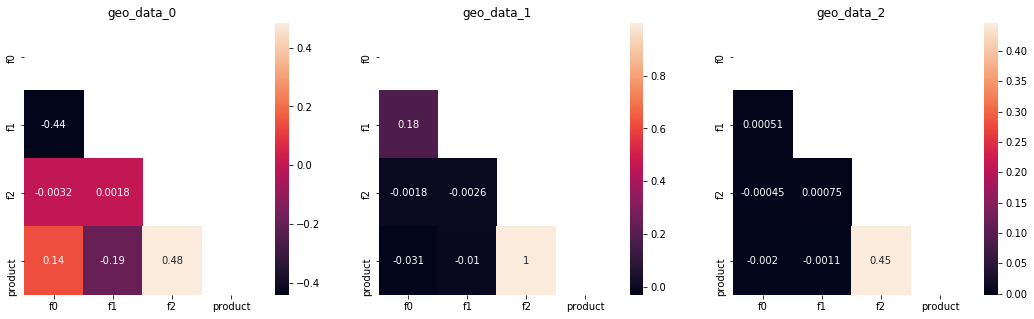

In [20]:

plt.subplots(1, 3, figsize=(18, 5))
plt.subplot(1, 3, 1).title.set_text('geo_data_0')
mask = np.triu(np.ones_like(geo_data_0.iloc[:, 1:].corr(), dtype=np.bool)) 
sns.heatmap(geo_data_0.iloc[:, 1:].corr(), annot=True, mask=mask);
plt.subplot(1, 3, 2).title.set_text('geo_data_1')
mask = np.triu(np.ones_like(geo_data_1.iloc[:, 1:].corr(), dtype=np.bool)) 
sns.heatmap(geo_data_1.iloc[:, 1:].corr(), annot=True, mask=mask);
plt.subplot(1, 3, 3).title.set_text('geo_data_2')
mask = np.triu(np.ones_like(geo_data_2.iloc[:, 1:].corr(), dtype=np.bool)) 
sns.heatmap(geo_data_2.iloc[:, 1:].corr(), annot=True, mask=mask);


Видно что наибольшая корреляция с целевой переменной имеет признак `f2`

In [21]:

coeffecients_for_geo_data_0 = pd.DataFrame(model_0.coef_, features_0_train.columns[1:])
coeffecients_for_geo_data_0.columns = ['Coeffecients_for_geo_data_0']
coeffecients_for_geo_data_1 = pd.DataFrame(model_1.coef_, features_1_train.columns[1:])
coeffecients_for_geo_data_1.columns = ['Coeffecients_for_geo_data_1']
coeffecients_for_geo_data_2 = pd.DataFrame(model_2.coef_, features_2_train.columns[1:])
coeffecients_for_geo_data_2.columns = ['Coeffecients_for_geo_data_2']
print(coeffecients_for_geo_data_0, '\n')
print(coeffecients_for_geo_data_1, '\n')
print(coeffecients_for_geo_data_2)


    Coeffecients_for_geo_data_0
f0                     3.674650
f1                   -14.121930
f2                     6.596011 

    Coeffecients_for_geo_data_1
f0                    -0.144894
f1                    -0.021825
f2                    26.950762 

    Coeffecients_for_geo_data_2
f0                    -0.055518
f1                    -0.082223
f2                     5.754654


Признак `f2` также имеет наибольший вес в `geo_data_1`, помимо полной корреляции.  
Возможно там стоит сосредоточиться именно на признаке `f2` при изучении новых точек для скважин.  
Это может сэкономить средства на разведке.

### Вывод:

Обучили модель и сделали предсказание используя линейную регрессию.  
Наименьшую ошибку модель показала на `geo_data_1`    
Средний запас сырья предсказан очень точно по сравнению со средними запасами в исходных датасетах.  
Видно что наибольшая корреляция с целевой переменной имеет признак `f2`  
Признак `f2` также имеет наибольший вес `geo_data_1`  
Возможно там стоит сосредоточиться именно на признаке `f2` при изучении новых точек для скважин.  
Это может сэкономить средства на разведке.  

## Подготовка к расчёту прибыли

Определим нужные константы для расчетов:

In [22]:

BUDGET_IN_REGION = 10_000_000_000
NUM_OF_POINTS_TO_EXPLORE = 500
NUM_OF_POINTS_TO_WORK_WITH = 200
REVENUE_PER_UNIT_OF_PRODUCT = 450_000
MILLION = 1_000_000
BILLION = 1_000_000_000


Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [23]:

MIN_PRODUCT_STOCK = BUDGET_IN_REGION / NUM_OF_POINTS_TO_WORK_WITH / REVENUE_PER_UNIT_OF_PRODUCT
MIN_PRODUCT_STOCK


111.11111111111111

Минимальный объем сырья для безубыточной работы скважины превышает средние значения запасов в каждом регионе.  
Далее мы отберем лучшие скважины в регионах.  
Напишем функцию для расчета прибыли:

In [24]:

predicted_0 = pd.Series(predicted_0)
predicted_1 = pd.Series(predicted_1)
predicted_2 = pd.Series(predicted_2)

def calculate_revenue(predicted, targets):
    '''This function selects the top 200 points by reserves and returns the revenue from their volume.
       The arguments are pd.Series objects, containing numbers (volume of product) and having length > 200.
       Returns float number.
    '''
    predicted_sorted = predicted.sort_values(ascending=False)
    sum_of_product = targets[predicted_sorted[:NUM_OF_POINTS_TO_WORK_WITH].index].sum()
    return sum_of_product * REVENUE_PER_UNIT_OF_PRODUCT - BUDGET_IN_REGION
    

### Вывод:

Определили нужные константы для расчета прибыли.  
Рассчитали достаточный объём сырья для безубыточной разработки новой скважины.  
Минимальный объем сырья для безубыточной работы скважины превышает средние значения запасов в каждом регионе.     
Далее мы отберем лучшие скважины в регионах.  
Напишем функцию для расчета прибыли.  

## Расчёт прибыли и рисков 

Найдем среднюю прибыль, **95%** доверительный интервал для каждого региона.  
Применим технику `Bootstrap` с **1000** выборок, чтобы найти распределение прибыли.   

Средняя прибыль в регионе "0" млн.руб.: 404.0
95%-ый доверительный интервал:       -138.0 903.0
Риск убытка:                            5.90 %

Средняя прибыль в регионе "1" млн.руб.: 439.0
95%-ый доверительный интервал:       32.0 846.0
Риск убытка:                            1.60 %

Средняя прибыль в регионе "2" млн.руб.: 368.0
95%-ый доверительный интервал:       -169.0 877.0
Риск убытка:                            8.00 %



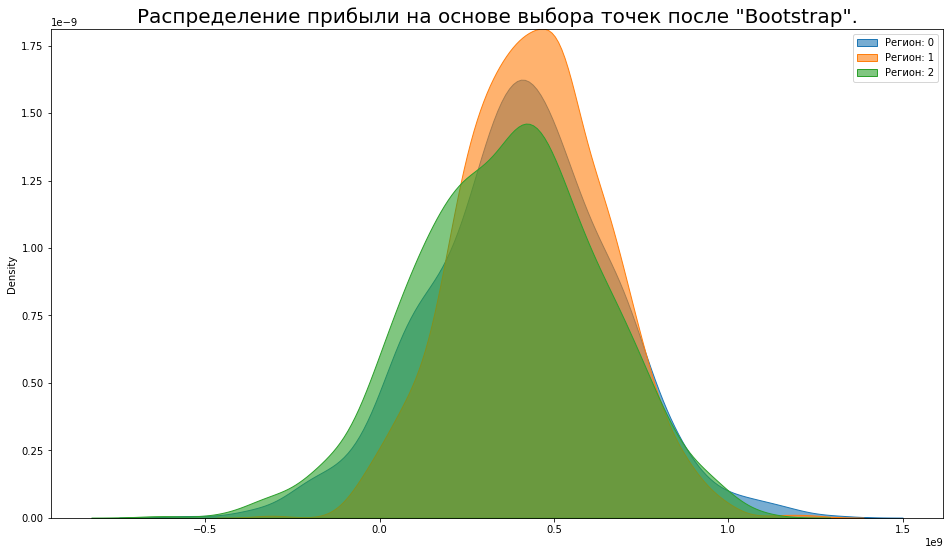

In [26]:

regions_predict = [predicted_0, predicted_1, predicted_2]

# сбросим индексы чтобы они соответствовали индексам предсказаний модели
targets_valid = [target_0_valid.reset_index(drop=True), 
                 target_1_valid.reset_index(drop=True), 
                 target_2_valid.reset_index(drop=True)
                ]
state = RandomState(42)
plt.figure(figsize=(16, 9))

# для каждого региона 1000 раз сделаем выборки из 500 точек и передадим их функции расчета прибыли
# функция каждый раз отберет лучшие по предсказанным запасам 200 из 500 точек и посчитает прибыль 
# посчитает уже на настоящих запасах по индексу точек и вернет нам прибыль которую мы запишем в общий список
# мы получим список с 1000 прибылями для каждого региона и расчитаем нужные значения

for index, region_predict in enumerate(regions_predict):
    values = []
    count = 0
    for i in range(1000):
        subsample = region_predict.sample(500, replace=True, random_state=state)
        values.append(calculate_revenue(subsample, pd.Series(targets_valid[index])))
    values = pd.Series(values)
    sns.kdeplot(values, shade=True, label='Регион: '+str(index), alpha=0.6)
    mean = values.mean()
    print('Средняя прибыль в регионе "{}" млн.руб.:'.format(index), (mean/MILLION).round())
    
    # так как у нас есть факт по прибыли, можно построить дов. интервал напрямую с помощью квантилей, 
    # не прибегая к моделированию распределения Стьюдента для выборки
    
    lower_limit = (values.quantile(0.025)/MILLION).round()
    upper_limit = (values.quantile(0.975)/MILLION).round()
    print('95%-ый доверительный интервал:', ' '*5, lower_limit, upper_limit)
    print('Риск убытка:', ' '*26, '{:.2f}'.format(stats.percentileofscore(values, 0, kind='strict')), '%\n')
plt.title('Распределение прибыли на основе выбора точек после "Bootstrap".', fontsize=20)
plt.legend()
plt.show()    
    

Снова регион 1 выделяется.  
Ранее мы уже видели что в нем наименьшая ошибка модели, и наибольшая корреляция со вторым признаком.  
Теперь видно что предварительно он самый прибыльный.  
Распределение прибыли показывает нам что именно в первом регионе наибольшое количество точек с потенциально большей прибылью, Распределение имеет меньший левый хвост из трех.  
У него самый высокий нижний порог доверительного интервала, и самый низкий риск убытка.

### Вывод:

В ходе нашего иследования однозначным лидером стал регион 1.  
Рекомендуется вести разработку именно там.

## Общий вывод:

В id есть повторы - следует уточнить какие признаки верны для данных id    
Cделано предсказание используя линейную регрессию.  
Наименьшую ошибку модель показала на регионе 1.  
Средний запас сырья предсказан очень точно по сравнению со средними запасами в исходных датасетах.  
Видно что наибольшая корреляция с целевой переменной имеет признак `f2`, в регионе 1 корреляция = 1.  
Признак `f2` также имеет наибольший вес в 2х моделях.  
Возможно в регионе 1 стоит сосредоточиться именно на признаке `f2` при изучении новых точек для скважин.  
Это может сэкономить средства на разведке.  
Рассчитан достаточный объём сырья для безубыточной разработки новой скважины исходя из бюджета на разработку **200** лучших скважин по запасам.    
Объем сырья для безубыточной работы скважины должен превышать **111 тыс.** баррелей что превосходит средние значения запасов в каждом регионе.      
Применена техника `Bootstrap` с **1000** выборок, чтобы найти распределение прибыли.  

 - Рекомендовано вести разработку в **регионе 1**: 
 - Там наилучшее распределение прибыли.
 - Наибольшая средняя прибыль: **439** млн.руб. (368, 404) остальные.
 - С вероятностью **95%** прибыль будет в диапазоне: **32:846** млн.руб. (-138:903, -169:877) остальные.
 - Риск убытка всего **1.6%** (5.9%, 8%) остальные.